In [1]:
import numpy
import tqdm
import scipy
import scipy.stats
import matplotlib
import matplotlib.pyplot
from joblib import dump, load
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

from calib import iso
%matplotlib inline

In [2]:
# specify the dataset settings (a mixutre of gaussian)

pi = numpy.array([0.5, 0.5])
ita_0 = numpy.array([0.5, 0.5])
ita_1 = numpy.array([0.5, 0.5])
mu_0_0 = numpy.array([4.0]) 
mu_0_1 = numpy.array([-64.0]) 
mu_1_0 = numpy.array([-4.0])
mu_1_1 = numpy.array([72.0 ]) 
cov_0_0 = numpy.array([960.0])
cov_0_1 = numpy.array([1280.0])
cov_1_0 = numpy.array([980.0])
cov_1_1 = numpy.array([1024.0])

In [3]:
# generate the feature and label samples

N = 10000
y = scipy.stats.multinomial.rvs(p=numpy.hstack([pi[0]*ita_0, pi[1]*ita_1]), size=N, n=1)
x = [scipy.stats.multivariate_normal.rvs(mean=mu_0_0, cov=cov_0_0, size=N).reshape(-1, 1),
     scipy.stats.multivariate_normal.rvs(mean=mu_0_1, cov=cov_0_1, size=N).reshape(-1, 1),
     scipy.stats.multivariate_normal.rvs(mean=mu_1_0, cov=cov_1_0, size=N).reshape(-1, 1),
     scipy.stats.multivariate_normal.rvs(mean=mu_1_1, cov=cov_1_1, size=N).reshape(-1, 1)]

x = x[0] * y[:, 0].reshape(-1, 1) + x[1] * y[:, 1].reshape(-1, 1) + \
    x[2] * y[:, 2].reshape(-1, 1) + x[3] * y[:, 3].reshape(-1, 1)

y = numpy.vstack([y[:, 0] + y[:, 1],
                  y[:, 2] + y[:, 3]]).transpose()

In [4]:
# train a NN classifier 
# mdl = load('models/mlp.joblib')

def test_prdict_proba(x, pi, ita_0, ita_1, mu_0_0, mu_0_1, mu_1_0, mu_1_1, cov_0_0, cov_0_1, cov_1_0, cov_1_1):
    p_x_y = numpy.vstack([pi[0] * ita_0[0] * scipy.stats.multivariate_normal.pdf(x=x, mean=mu_0_0, cov=cov_0_0) +
                          pi[1] * ita_0[1] * scipy.stats.multivariate_normal.pdf(x=x, mean=mu_0_1, cov=cov_0_1),
                          pi[1] * ita_1[0] * scipy.stats.multivariate_normal.pdf(x=x, mean=mu_1_0, cov=cov_1_0) +
                          pi[1] * ita_1[1] * scipy.stats.multivariate_normal.pdf(x=x, mean=mu_1_1, cov=cov_1_1)])
    p_x =  numpy.sum(p_x_y, axis=0)
    
    res = numpy.transpose(p_x_y / p_x)
    
    res[:, 1] = numpy.clip((res[:, 1] - 0.5) * 2.0 + 0.5, 0, 1)
    res[:, 0] = 1 - res[:, 1]
    
    # mdl = load('models/mlp.joblib')
    # res = mdl.predict_proba(x)

    return res

In [5]:
# get predicted scores on samples
# s = mdl.predict_proba(x)
s = test_prdict_proba(x, pi, ita_0, ita_1, mu_0_0, mu_0_1, mu_1_0, mu_1_1, cov_0_0, cov_0_1, cov_1_0, cov_1_1)

In [6]:
# get predicted scores on an interval
N_grid = 64
edge = 160.0
v_edge = 160.0
x_mesh = numpy.linspace(-edge, edge, N_grid).reshape(-1, 1)
# s_mesh = mdl.predict_proba(x_mesh)
s_mesh = test_prdict_proba(x_mesh, pi, ita_0, ita_1, mu_0_0, mu_0_1, mu_1_0, mu_1_1, cov_0_0, cov_0_1, cov_1_0, cov_1_1)

In [7]:
# calculate the corresponding densities and probabilities

p_x_y = numpy.vstack([pi[0] * ita_0[0] * scipy.stats.multivariate_normal.pdf(x=x_mesh, mean=mu_0_0, cov=cov_0_0) +
                      pi[1] * ita_0[1] * scipy.stats.multivariate_normal.pdf(x=x_mesh, mean=mu_0_1, cov=cov_0_1),
                      pi[1] * ita_1[0] * scipy.stats.multivariate_normal.pdf(x=x_mesh, mean=mu_1_0, cov=cov_1_0) +
                      pi[1] * ita_1[1] * scipy.stats.multivariate_normal.pdf(x=x_mesh, mean=mu_1_1, cov=cov_1_1)])

p_x =  numpy.sum(p_x_y, axis=0)

p_true = p_x_y / p_x

In [8]:
# matplotlib.pyplot.figure(dpi=128, figsize=(5, 5))
# matplotlib.pyplot.plot(x_mesh, s_mesh[:, 0], 'k', linewidth=3.0)
# matplotlib.pyplot.plot(x[y[:, 0]==1], numpy.zeros(numpy.sum(y[:, 0]==1)), 'bo', markersize=3, alpha=0.01)
# matplotlib.pyplot.plot(x[y[:, 0]==0], numpy.zeros(numpy.sum(y[:, 0]==0)), 'ro', markersize=3, alpha=0.01)
# matplotlib.pyplot.ylim([0, 1])
# matplotlib.pyplot.xlabel('x')
# matplotlib.pyplot.ylabel('s')
# matplotlib.pyplot.title('MLP: prediction')
# matplotlib.pyplot.ylim([-0.05, 1.05])
# matplotlib.pyplot.grid()

In [9]:
N = int(4096)
N_sim = int(1e4)

p_s = numpy.zeros(N_grid-1)
p_s_0 = numpy.zeros(N_grid-1)
p_s_1 = numpy.zeros(N_grid-1)

# p_s_hat = numpy.zeros(N_grid - 1)
# p_s_0_hat = numpy.zeros(N_grid - 1)
# p_s_1_hat = numpy.zeros(N_grid - 1)

for i in tqdm.trange(0, N_sim):
    tmp_y = scipy.stats.multinomial.rvs(p=numpy.hstack([pi[0]*ita_0, pi[1]*ita_1]), size=N, n=1)

    tmp_x = [scipy.stats.multivariate_normal.rvs(mean=mu_0_0, cov=cov_0_0, size=N).reshape(-1, 1),
             scipy.stats.multivariate_normal.rvs(mean=mu_0_1, cov=cov_0_1, size=N).reshape(-1, 1),
             scipy.stats.multivariate_normal.rvs(mean=mu_1_0, cov=cov_1_0, size=N).reshape(-1, 1),
             scipy.stats.multivariate_normal.rvs(mean=mu_1_1, cov=cov_1_1, size=N).reshape(-1, 1)]

    tmp_x = tmp_x[0] * tmp_y[:, 0].reshape(-1, 1) + tmp_x[1] * tmp_y[:, 1].reshape(-1, 1) + \
            tmp_x[2] * tmp_y[:, 2].reshape(-1, 1) + tmp_x[3] * tmp_y[:, 3].reshape(-1, 1)

    tmp_y = numpy.vstack([tmp_y[:, 0] + tmp_y[:, 1],
                          tmp_y[:, 2] + tmp_y[:, 3]]).transpose()

    # tmp_s = mdl.predict_proba(tmp_x)
    tmp_s = test_prdict_proba(tmp_x, pi, ita_0, ita_1, mu_0_0, mu_0_1, mu_1_0, mu_1_1, cov_0_0, cov_0_1, cov_1_0, cov_1_1)
    
    # s_hat = cal.predict_proba(s)

    p_s = p_s + numpy.histogram(tmp_s[:, 0], bins=numpy.linspace(0, 1, N_grid))[0]
    p_s_0 = p_s_0 + numpy.histogram(tmp_s[tmp_y[:, 0]==1, 0], bins=numpy.linspace(0, 1, N_grid))[0]
    p_s_1 = p_s_1 + numpy.histogram(tmp_s[tmp_y[:, 1]==1, 0], bins=numpy.linspace(0, 1, N_grid))[0]

    # p_s_hat = p_s_hat + numpy.histogram(s_hat[:, 0], bins=numpy.linspace(0, 1, N_grid))[0]
    # p_s_0_hat = p_s_0_hat + numpy.histogram(s_hat[y[:, 0]==1, 0], bins=numpy.linspace(0, 1, N_grid))[0]
    # p_s_1_hat = p_s_1_hat + numpy.histogram(s_hat[y[:, 1]==1, 0], bins=numpy.linspace(0, 1, N_grid))[0]
                                                    
p_s = p_s + 1
p_s_0 = p_s_0 + 1
p_s_1 = p_s_1 + 1

# p_s_hat = p_s_hat
# p_s_0_hat = p_s_0_hat
# p_s_1_hat = p_s_1_hat

100%|██████████| 10000/10000 [00:33<00:00, 299.89it/s]


In [10]:
# calculate related probabilities

p_x_y_hat = numpy.vstack([pi[0] * p_s_0.ravel(),
                          pi[1] * p_s_1.ravel()])

p_x_hat =  numpy.sum(p_x_y_hat, axis=0)

p_y_hat = p_x_y_hat / p_x_hat

In [11]:
# draw reliability diagram

# matplotlib.pyplot.figure(dpi=128, figsize=(5, 5))
# matplotlib.pyplot.plot(numpy.linspace(0, 1, N_grid-1), p_y_hat[0, :], 'k', linewidth=3)
# matplotlib.pyplot.plot(s[y[:, 0]==1, 0], numpy.zeros(numpy.sum(y[:, 0]==1)), 'bo', markersize=3, alpha=0.01)
# matplotlib.pyplot.plot(s[y[:, 0]==0, 0], numpy.zeros(numpy.sum(y[:, 0]==0)), 'ro', markersize=3, alpha=0.01)
# matplotlib.pyplot.xlabel('s')
# matplotlib.pyplot.ylabel('p(y=1 | s)')
# matplotlib.pyplot.title('MLP: reliability diagram')
# matplotlib.pyplot.grid()

In [12]:
cal = iso()
cal.fit(s, y)

In [13]:
s_mesh_hat = cal.predict_proba(s_mesh)

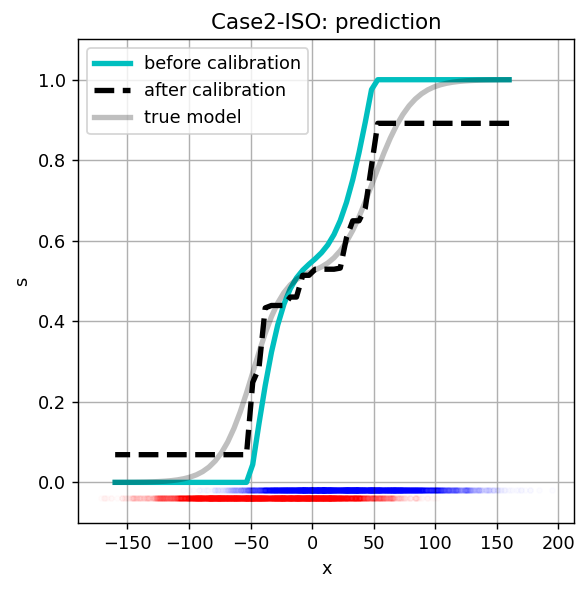

In [14]:
matplotlib.pyplot.figure(dpi=128, figsize=(5, 5))
matplotlib.pyplot.plot(-x_mesh, s_mesh[:, 0], 'c', linewidth=3.0)
matplotlib.pyplot.plot(-x_mesh, s_mesh_hat[:, 0], 'k--', linewidth=3)
matplotlib.pyplot.plot(-x_mesh, p_true[0], 'k', linewidth=3.0, alpha=0.25)
matplotlib.pyplot.plot(-x[y[:, 0]==1], numpy.zeros(numpy.sum(y[:, 0]==1)) - 2e-2, 'bo', markersize=3, alpha=0.01)
matplotlib.pyplot.plot(-x[y[:, 0]==0], numpy.zeros(numpy.sum(y[:, 0]==0)) - 4e-2, 'ro', markersize=3, alpha=0.01)
# matplotlib.pyplot.ylim([0, 1])
matplotlib.pyplot.xlabel('x')
matplotlib.pyplot.ylabel('s')
matplotlib.pyplot.title('Case2-ISO: prediction')
matplotlib.pyplot.ylim([-0.1, 1.1])
matplotlib.pyplot.grid()
matplotlib.pyplot.legend(['before calibration', 'after calibration', 'true model'])

In [15]:
N = int(4096)
N_sim = int(5e4)

p_s_hat = numpy.zeros(N_grid-1)
p_s_0_hat = numpy.zeros(N_grid-1)
p_s_1_hat = numpy.zeros(N_grid-1)

# p_s_hat = numpy.zeros(N_grid - 1)
# p_s_0_hat = numpy.zeros(N_grid - 1)
# p_s_1_hat = numpy.zeros(N_grid - 1)

for i in tqdm.trange(0, N_sim):
    tmp_y = scipy.stats.multinomial.rvs(p=numpy.hstack([pi[0]*ita_0, pi[1]*ita_1]), size=N, n=1)

    tmp_x = [scipy.stats.multivariate_normal.rvs(mean=mu_0_0, cov=cov_0_0, size=N).reshape(-1, 1),
             scipy.stats.multivariate_normal.rvs(mean=mu_0_1, cov=cov_0_1, size=N).reshape(-1, 1),
             scipy.stats.multivariate_normal.rvs(mean=mu_1_0, cov=cov_1_0, size=N).reshape(-1, 1),
             scipy.stats.multivariate_normal.rvs(mean=mu_1_1, cov=cov_1_1, size=N).reshape(-1, 1)]

    tmp_x = tmp_x[0] * tmp_y[:, 0].reshape(-1, 1) + tmp_x[1] * tmp_y[:, 1].reshape(-1, 1) + \
            tmp_x[2] * tmp_y[:, 2].reshape(-1, 1) + tmp_x[3] * tmp_y[:, 3].reshape(-1, 1)

    tmp_y = numpy.vstack([tmp_y[:, 0] + tmp_y[:, 1],
                          tmp_y[:, 2] + tmp_y[:, 3]]).transpose()

    # tmp_s = mdl.predict_proba(tmp_x)
    tmp_s = test_prdict_proba(tmp_x, pi, ita_0, ita_1, mu_0_0, mu_0_1, mu_1_0, mu_1_1, cov_0_0, cov_0_1, cov_1_0, cov_1_1)
    
    tmp_s = cal.predict_proba(tmp_s)

    p_s_hat = p_s_hat + numpy.histogram(tmp_s[:, 0], bins=numpy.linspace(0, 1, N_grid))[0]
    p_s_0_hat = p_s_0_hat + numpy.histogram(tmp_s[tmp_y[:, 0]==1, 0], bins=numpy.linspace(0, 1, N_grid))[0]
    p_s_1_hat = p_s_1_hat + numpy.histogram(tmp_s[tmp_y[:, 1]==1, 0], bins=numpy.linspace(0, 1, N_grid))[0]

    # p_s_hat = p_s_hat + numpy.histogram(s_hat[:, 0], bins=numpy.linspace(0, 1, N_grid))[0]
    # p_s_0_hat = p_s_0_hat + numpy.histogram(s_hat[y[:, 0]==1, 0], bins=numpy.linspace(0, 1, N_grid))[0]
    # p_s_1_hat = p_s_1_hat + numpy.histogram(s_hat[y[:, 1]==1, 0], bins=numpy.linspace(0, 1, N_grid))[0]
                                                    
p_s_hat = p_s_hat
p_s_0_hat = p_s_0_hat
p_s_1_hat = p_s_1_hat

# p_s_hat = p_s_hat
# p_s_0_hat = p_s_0_hat
# p_s_1_hat = p_s_1_hat

100%|██████████| 50000/50000 [02:42<00:00, 306.78it/s]


In [16]:
# calculate related probabilities

p_x_y_hat = numpy.vstack([pi[0] * p_s_0_hat.ravel(),
                          pi[1] * p_s_1_hat.ravel()])

p_x_hat =  numpy.sum(p_x_y_hat, axis=0)

p_y_hat_hat = p_x_y_hat / p_x_hat

/home/sh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


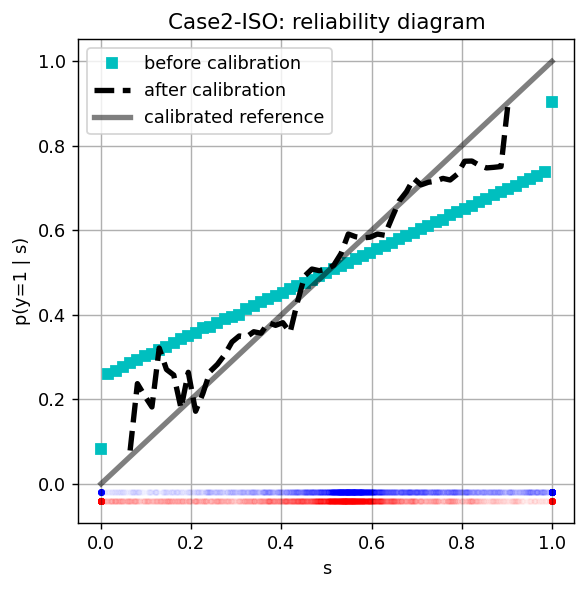

In [17]:
# draw reliability diagram

matplotlib.pyplot.figure(dpi=128, figsize=(5, 5))
matplotlib.pyplot.plot(numpy.linspace(0, 1, N_grid-1), p_y_hat[0, :], 'cs', linewidth=3)
matplotlib.pyplot.plot(numpy.linspace(0, 1, N_grid-1), p_y_hat_hat[0, :], 'k--', linewidth=3)
matplotlib.pyplot.plot(numpy.linspace(0, 1, N_grid-1), numpy.linspace(0, 1, N_grid-1), 'k', linewidth=3, alpha=0.5)
matplotlib.pyplot.plot(s[y[:, 0]==1, 0], numpy.zeros(numpy.sum(y[:, 0]==1)) - 2e-2, 'bo', markersize=3, alpha=0.01)
matplotlib.pyplot.plot(s[y[:, 0]==0, 0], numpy.zeros(numpy.sum(y[:, 0]==0)) - 4e-2, 'ro', markersize=3, alpha=0.01)
matplotlib.pyplot.xlabel('s')
matplotlib.pyplot.ylabel('p(y=1 | s)')
matplotlib.pyplot.title('Case2-ISO: reliability diagram')
matplotlib.pyplot.grid()
matplotlib.pyplot.legend(['before calibration', 'after calibration', 'calibrated reference'])

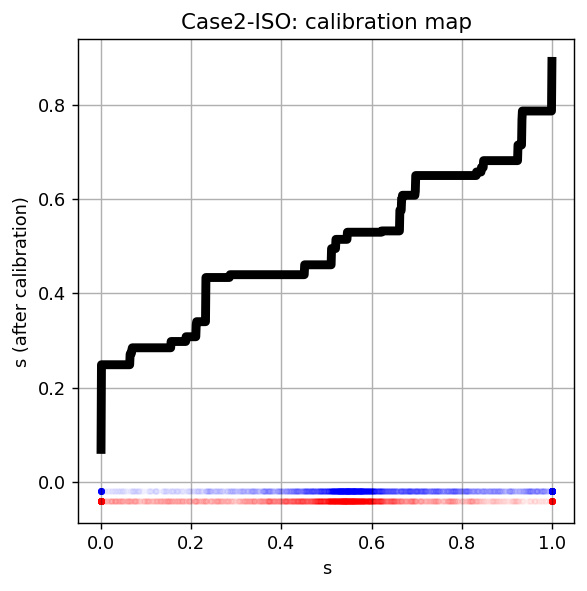

In [18]:
# draw calibration map

s_list = numpy.linspace(0, 1, 1024)
s_hat = cal.predict_proba(numpy.hstack([s_list.reshape(-1, 1), 1-s_list.reshape(-1, 1)]))

matplotlib.pyplot.figure(dpi=128, figsize=(5, 5))
matplotlib.pyplot.plot(s_list, s_hat[:, 0], 'k', linewidth=5.0)
matplotlib.pyplot.plot(s[y[:, 0]==1, 0], numpy.zeros(numpy.sum(y[:, 0]==1)) - 2e-2, 'bo', markersize=3, alpha=0.01)
matplotlib.pyplot.plot(s[y[:, 0]==0, 0], numpy.zeros(numpy.sum(y[:, 0]==0)) - 4e-2, 'ro', markersize=3, alpha=0.01)
matplotlib.pyplot.xlabel('s')
matplotlib.pyplot.ylabel('s (after calibration)')
matplotlib.pyplot.title('Case2-ISO: calibration map')
matplotlib.pyplot.grid()

In [ ]:
# try with more samples

N = 100000 
y = scipy.stats.multinomial.rvs(p=numpy.hstack([pi[0]*ita_0, pi[1]*ita_1]), size=N, n=1)
x = [scipy.stats.multivariate_normal.rvs(mean=mu_0_0, cov=cov_0_0, size=N).reshape(-1, 1),
     scipy.stats.multivariate_normal.rvs(mean=mu_0_1, cov=cov_0_1, size=N).reshape(-1, 1),
     scipy.stats.multivariate_normal.rvs(mean=mu_1_0, cov=cov_1_0, size=N).reshape(-1, 1),
     scipy.stats.multivariate_normal.rvs(mean=mu_1_1, cov=cov_1_1, size=N).reshape(-1, 1)]

x = x[0] * y[:, 0].reshape(-1, 1) + x[1] * y[:, 1].reshape(-1, 1) + \
    x[2] * y[:, 2].reshape(-1, 1) + x[3] * y[:, 3].reshape(-1, 1)

y = numpy.vstack([y[:, 0] + y[:, 1],
                  y[:, 2] + y[:, 3]]).transpose()

s = mdl.predict_proba(x)

In [ ]:
cal = iso()
cal.fit(s, y)

In [ ]:
s_mesh_hat = cal.predict_proba(s_mesh)

In [ ]:
matplotlib.pyplot.figure(dpi=128, figsize=(5, 5))
matplotlib.pyplot.plot(-x_mesh, s_mesh[:, 0], 'c', linewidth=3.0)
matplotlib.pyplot.plot(-x_mesh, s_mesh_hat[:, 0], 'k--', linewidth=3)
matplotlib.pyplot.plot(-x_mesh, p_true[0], 'k', linewidth=3.0, alpha=0.25)
matplotlib.pyplot.plot(-x[y[:, 0]==1], numpy.zeros(numpy.sum(y[:, 0]==1)) - 2e-2, 'bo', markersize=3, alpha=0.01)
matplotlib.pyplot.plot(-x[y[:, 0]==0], numpy.zeros(numpy.sum(y[:, 0]==0)) - 4e-2, 'ro', markersize=3, alpha=0.01)
# matplotlib.pyplot.ylim([0, 1])
matplotlib.pyplot.xlabel('x')
matplotlib.pyplot.ylabel('s')
matplotlib.pyplot.title('MLP-ISO: prediction')
matplotlib.pyplot.ylim([-0.1, 1.1])
matplotlib.pyplot.grid()
matplotlib.pyplot.legend(['before calibration', 'after calibration', 'true model'])

In [ ]:
N = int(4096)
N_sim = int(5e4)

p_s_hat = numpy.zeros(N_grid-1)
p_s_0_hat = numpy.zeros(N_grid-1)
p_s_1_hat = numpy.zeros(N_grid-1)

# p_s_hat = numpy.zeros(N_grid - 1)
# p_s_0_hat = numpy.zeros(N_grid - 1)
# p_s_1_hat = numpy.zeros(N_grid - 1)

for i in tqdm.trange(0, N_sim):
    tmp_y = scipy.stats.multinomial.rvs(p=numpy.hstack([pi[0]*ita_0, pi[1]*ita_1]), size=N, n=1)

    tmp_x = [scipy.stats.multivariate_normal.rvs(mean=mu_0_0, cov=cov_0_0, size=N).reshape(-1, 1),
             scipy.stats.multivariate_normal.rvs(mean=mu_0_1, cov=cov_0_1, size=N).reshape(-1, 1),
             scipy.stats.multivariate_normal.rvs(mean=mu_1_0, cov=cov_1_0, size=N).reshape(-1, 1),
             scipy.stats.multivariate_normal.rvs(mean=mu_1_1, cov=cov_1_1, size=N).reshape(-1, 1)]

    tmp_x = tmp_x[0] * tmp_y[:, 0].reshape(-1, 1) + tmp_x[1] * tmp_y[:, 1].reshape(-1, 1) + \
            tmp_x[2] * tmp_y[:, 2].reshape(-1, 1) + tmp_x[3] * tmp_y[:, 3].reshape(-1, 1)

    tmp_y = numpy.vstack([tmp_y[:, 0] + tmp_y[:, 1],
                          tmp_y[:, 2] + tmp_y[:, 3]]).transpose()

    tmp_s = mdl.predict_proba(tmp_x)
    
    tmp_s = cal.predict_proba(tmp_s)

    p_s_hat = p_s_hat + numpy.histogram(tmp_s[:, 0], bins=numpy.linspace(0, 1, N_grid))[0]
    p_s_0_hat = p_s_0_hat + numpy.histogram(tmp_s[tmp_y[:, 0]==1, 0], bins=numpy.linspace(0, 1, N_grid))[0]
    p_s_1_hat = p_s_1_hat + numpy.histogram(tmp_s[tmp_y[:, 1]==1, 0], bins=numpy.linspace(0, 1, N_grid))[0]

    # p_s_hat = p_s_hat + numpy.histogram(s_hat[:, 0], bins=numpy.linspace(0, 1, N_grid))[0]
    # p_s_0_hat = p_s_0_hat + numpy.histogram(s_hat[y[:, 0]==1, 0], bins=numpy.linspace(0, 1, N_grid))[0]
    # p_s_1_hat = p_s_1_hat + numpy.histogram(s_hat[y[:, 1]==1, 0], bins=numpy.linspace(0, 1, N_grid))[0]
                                                    
p_s_hat = p_s_hat
p_s_0_hat = p_s_0_hat
p_s_1_hat = p_s_1_hat

# p_s_hat = p_s_hat
# p_s_0_hat = p_s_0_hat
# p_s_1_hat = p_s_1_hat

In [ ]:
# calculate related probabilities

p_x_y_hat = numpy.vstack([pi[0] * p_s_0_hat.ravel(),
                          pi[1] * p_s_1_hat.ravel()])

p_x_hat =  numpy.sum(p_x_y_hat, axis=0)

p_y_hat_hat = p_x_y_hat / p_x_hat

In [ ]:
# draw reliability diagram

matplotlib.pyplot.figure(dpi=128, figsize=(5, 5))
matplotlib.pyplot.plot(numpy.linspace(0, 1, N_grid-1), p_y_hat[0, :], 'c', linewidth=3)
matplotlib.pyplot.plot(numpy.linspace(0, 1, N_grid-1), p_y_hat_hat[0, :], 'k--', linewidth=3)
matplotlib.pyplot.plot(numpy.linspace(0, 1, N_grid-1), numpy.linspace(0, 1, N_grid-1), 'k', linewidth=3, alpha=0.5)
matplotlib.pyplot.plot(s[y[:, 0]==1, 0], numpy.zeros(numpy.sum(y[:, 0]==1)) - 2e-2, 'bo', markersize=3, alpha=0.01)
matplotlib.pyplot.plot(s[y[:, 0]==0, 0], numpy.zeros(numpy.sum(y[:, 0]==0)) - 4e-2, 'ro', markersize=3, alpha=0.01)
matplotlib.pyplot.xlabel('s')
matplotlib.pyplot.ylabel('p(y=1 | s)')
matplotlib.pyplot.title('MLP-ISO: reliability diagram')
matplotlib.pyplot.grid()
matplotlib.pyplot.legend(['before calibration', 'after calibration', 'calibrated reference'])

In [ ]:
# draw calibration map

s_list = numpy.linspace(0, 1, 1024)
s_hat = cal.predict_proba(numpy.hstack([s_list.reshape(-1, 1), 1-s_list.reshape(-1, 1)]))

matplotlib.pyplot.figure(dpi=128, figsize=(5, 5))
matplotlib.pyplot.plot(s_list, s_hat[:, 0], 'k', linewidth=5.0)
matplotlib.pyplot.plot(s[y[:, 0]==1, 0], numpy.zeros(numpy.sum(y[:, 0]==1)) - 2e-2, 'bo', markersize=3, alpha=0.01)
matplotlib.pyplot.plot(s[y[:, 0]==0, 0], numpy.zeros(numpy.sum(y[:, 0]==0)) - 4e-2, 'ro', markersize=3, alpha=0.01)
matplotlib.pyplot.xlabel('s')
matplotlib.pyplot.ylabel('s (after calibration)')
matplotlib.pyplot.title('MLP-ISO: calibration map')
matplotlib.pyplot.grid()